# Task 1

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.stats as smstats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf
import scipy.stats as stats


# apikey = UP3EYYQQF45BSJL7
url_aapl = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=AAPL&outputsize=full&datatype=json&apikey=9FJH86DPVIOL3UWJ'
url_googl = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=GOOGL&outputsize=full&datatype=json&apikey=9FJH86DPVIOL3UWJ'
url_fb = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=FB&outputsize=full&datatype=json&apikey=9FJH86DPVIOL3UWJ'

r_aapl = requests.get(url_aapl)
r_googl = requests.get(url_googl)
r_fb = requests.get(url_fb)

In [2]:
def stock_close_10(url, ticker):
    r = requests.get(url)
    
    # retrieving pandas dataframes
    data = pd.DataFrame.from_dict(r.json()['Time Series (Daily)'], orient='index')
    
    # dropping the rest of the columns (we are using 'adjusted close' values only)
    close = data['5. adjusted close']
    
    # dropping data past last 10 years, renaming columns, typecasting
    close_10 = close.loc['2021-06-18':'2011-06-17'].to_frame().rename(columns={"5. adjusted close": ticker}).astype('d')
    return close_10

In [4]:
aapl_close_10 = stock_close_10(url_aapl, "AAPL")
googl_close_10 = stock_close_10(url_googl, "GOOGL")
fb_close_10 = stock_close_10(url_fb, "FB")

In [5]:
# concatenating into one DataFrame
daily_close = pd.concat([aapl_close_10, googl_close_10, fb_close_10], axis=1, sort=False)
daily_close.index = pd.to_datetime(daily_close.index)

daily_close.head()

,AAPL,GOOGL,FB
2021-06-18,130.46,2402.22,329.66
2021-06-17,131.79,2434.87,336.51
2021-06-16,130.15,2415.45,331.08
2021-06-15,129.64,2428.39,336.75
2021-06-14,130.48,2448.91,336.77


In [6]:
# basic descriptive statistics
daily_close.describe()

,AAPL,GOOGL,FB
count,2518.000000,2518.000000,2286.000000
mean,39.843032,859.003728,132.679271
std,31.221999,468.544339,76.161889
min,9.682574,238.175224,17.729000
25%,18.589870,519.278332,74.142500
50%,27.522508,766.510000,127.940000
75%,46.418776,1140.652500,181.752500
max,142.704617,2448.910000,336.770000


In [7]:
# setting plots parameters, seed
%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 8)
np.random.seed(9)

C:\Users\ivank\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


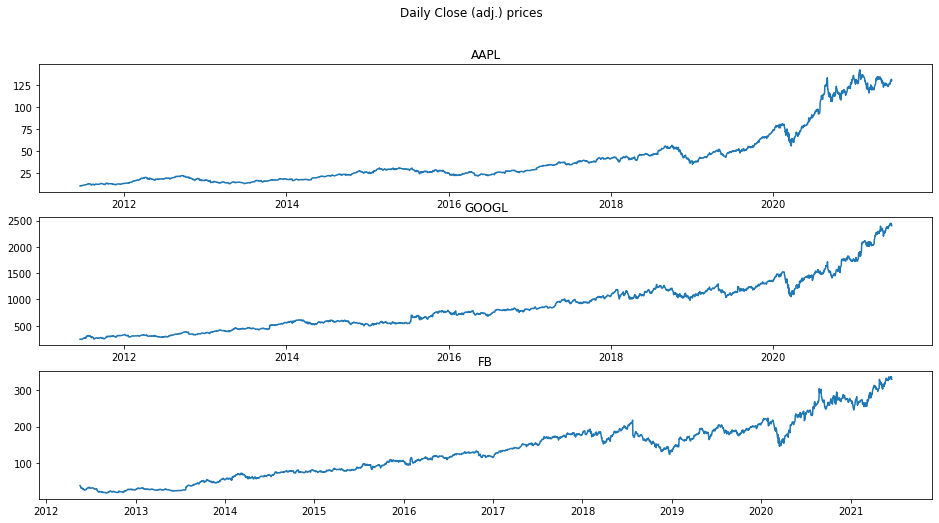

In [8]:
# we should plot daily prices now
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.suptitle('Daily Close (adj.) prices')
ax1.plot(daily_close.AAPL)
ax1.set_title('AAPL')
ax2.plot(daily_close.GOOGL)
ax2.set_title('GOOGL')
ax3.plot(daily_close.FB)
ax3.set_title('FB')

plt.show()

# Task 2

In [9]:
# obtaining returns
daily_returns = daily_close.diff(-1)

daily_returns.head()

,AAPL,GOOGL,FB
2021-06-18,-1.33,-32.65,-6.85
2021-06-17,1.64,19.42,5.43
2021-06-16,0.51,-12.94,-5.67
2021-06-15,-0.84,-20.52,-0.02
2021-06-14,3.13,18.71,5.51


In [10]:
# descriptive analysis of returns

daily_returns.describe()

,AAPL,GOOGL,FB
count,2517.000000,2517.000000,2285.000000
mean,0.047924,0.857751,0.127540
std,1.056660,16.665553,3.220129
min,-10.468456,-141.270000,-41.240000
25%,-0.193687,-4.278206,-0.905000
50%,0.022602,0.616904,0.090000
75%,0.289568,6.334554,1.260000
max,10.002207,139.760000,23.090000


### AAPL

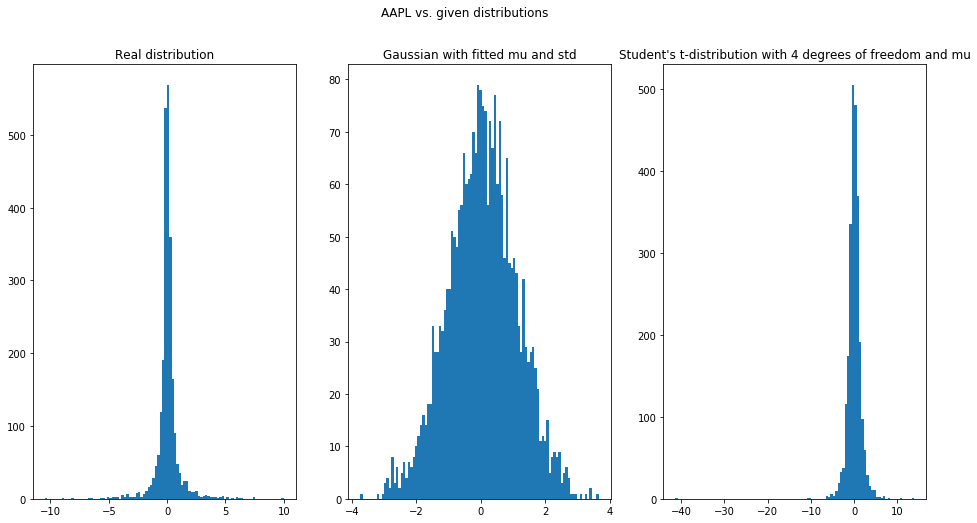

In [12]:
# let's start with visualizations

def returns_vs_plots(daily_returns, ticker, df=4, plot=True):
    np.random.seed(9)
    
    # retrieving count, mean and std of ticker
    n = daily_returns[ticker].describe().loc['count'].astype(int)
    mu = daily_returns[ticker].describe().loc['mean']
    std = daily_returns[ticker].describe().loc['std']
    
    # dropping NaNs = getting only first n instances
    returns = np.array(daily_returns[ticker])[:n]
    
    # considering given distributions
    gaussian = np.random.normal(mu, std, n)
    student = np.random.standard_t(df, n) + mu
    
    if plot:
        # plotting returns vs these dists
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        fig.suptitle(ticker + ' vs. given distributions')
        ax1.hist(returns, bins=100)
        ax1.set_title('Real distribution')
        ax2.hist(gaussian, bins=100)
        ax2.set_title('Gaussian with fitted mu and std')
        ax3.hist(student, bins=100)
        ax3.set_title("Student's t-distribution with " + str(df) + " degrees of freedom and mu")

        plt.show()
    
    return n, mu, std, returns, gaussian, student

# firstly, we will consider AAPL vs given dists
n_aapl, mu_aapl, std_aapl, returns_aapl, gaussian_aapl, student_aapl = returns_vs_plots(daily_returns, 'AAPL')

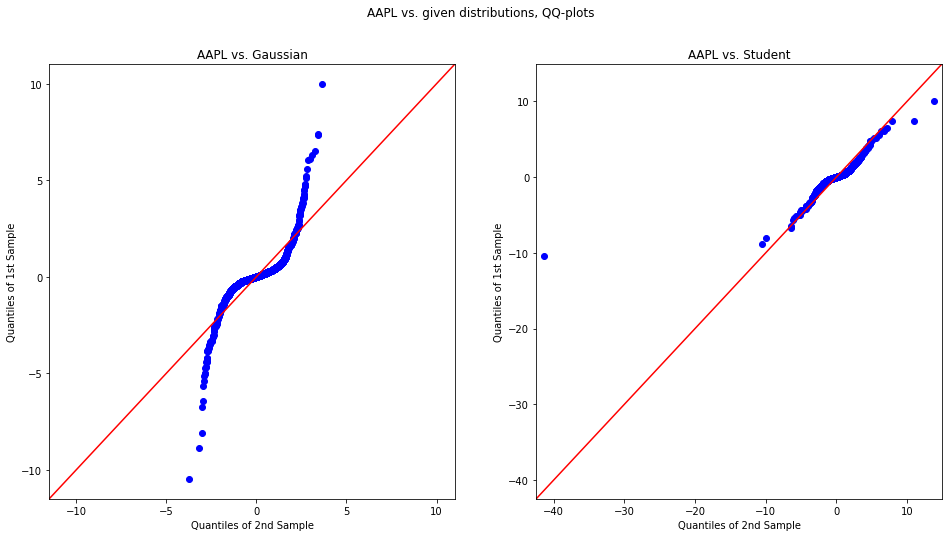

In [13]:
# let's move on to qqplots

def qqplots(daily_returns, ticker, df=4):
    
    _, _, _, returns, gaussian, student = returns_vs_plots(daily_returns, ticker, df=df, plot=False)
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(ticker + ' vs. given distributions, QQ-plots')
    ax1.set_title(ticker + ' vs. Gaussian')
    ax2.set_title(ticker + ' vs. Student')
    sm.qqplot(returns, other=gaussian, line='45', ax=ax1)
    sm.qqplot(returns, other=student, line='45', ax=ax2)
    
    plt.show()
    
qqplots(daily_returns, 'AAPL')

# qqplots are not very close to a line => doesn't look like gaussian or student

In [14]:
# finally, let's run some goodness of fit tests

def goodness_of_fit_tests(daily_returns, ticker):
    _, _, _, returns, _, _ = returns_vs_plots(daily_returns, ticker, plot=False)
    
    # Lilliefors’ tests
    ks_norm = smstats.diagnostic.kstest_normal(returns)
    ks_exp = smstats.diagnostic.kstest_exponential(returns)
    
    return pd.DataFrame([ks_norm, ks_exp], index=['Lilliefors_norm', 'Lilliefors_exp'], columns=['statistic', 'pvalue'])

goodness_of_fit_tests(daily_returns, 'AAPL')

# pvalues are smaller than 0.05 => rejecting both null hypotheses (that returns are normally or exponentially distributed) at 0.05 level

,statistic,pvalue
Lilliefors_norm,0.187973,1.118369e-249
Lilliefors_exp,0.473182,1.000000e-02


ADF Statistic: -10.209624
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


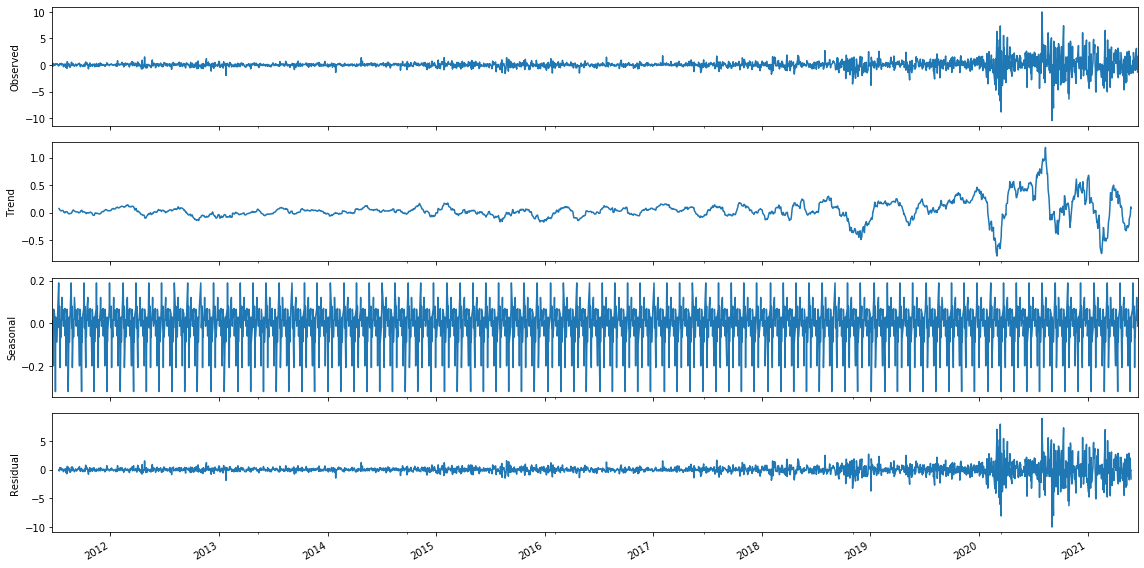

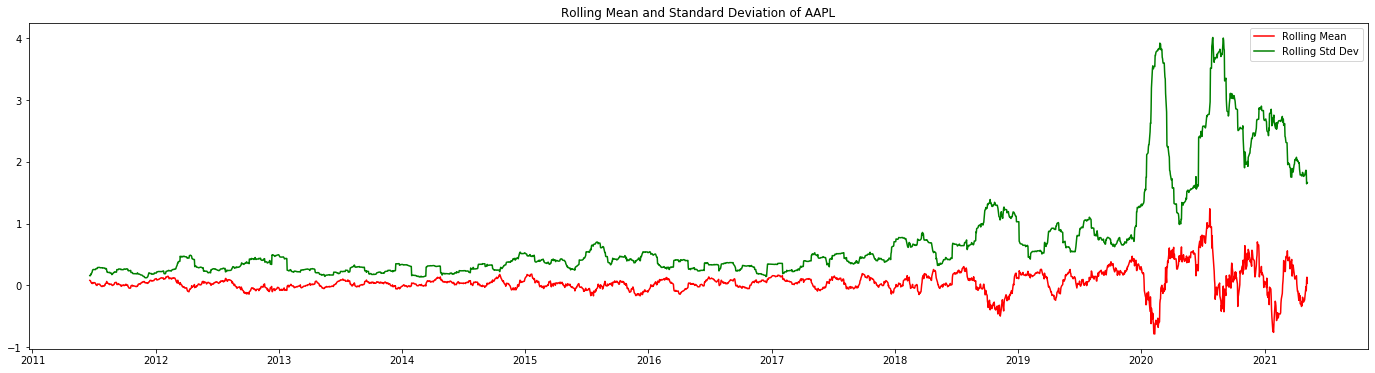

In [15]:
# moving on to a stationary analysis of returns

def stationary_analysis(daily_returns, ticker):
    returns = daily_returns[ticker].dropna()
    
    result = adfuller(returns)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    decomposition = seasonal_decompose(returns.to_frame(), freq=30)
    decomposition.plot()
    
    # calculating rolling mean and rolling standard deviation:
    rolling_mean = returns.rolling(30).mean()
    rolling_std_dev = returns.rolling(30).std()
    
    plt.figure(figsize=(24, 6))
    plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='green', label='Rolling Std Dev')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation of ' + ticker)
    
    
    plt.show()
    
stationary_analysis(daily_returns, 'AAPL')

# highly unlikely that our data is stationary as rolling mean and std are changing in time
# and pvalue for ADF test is 0, so we reject the null hypothesis that the data is stationary

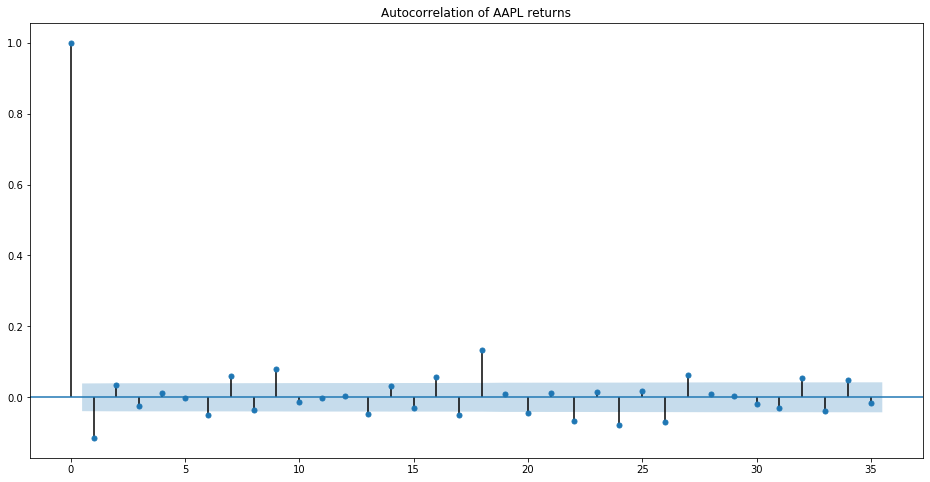

In [16]:
# to see if there is any dependency of time series values to their previous values, we will use autocorrelation function

plot_acf(returns_aapl, title='Autocorrelation of AAPL returns')
plt.show()

# as values of acf are close to zero, there is probably no dependency in our data

### GOOGL

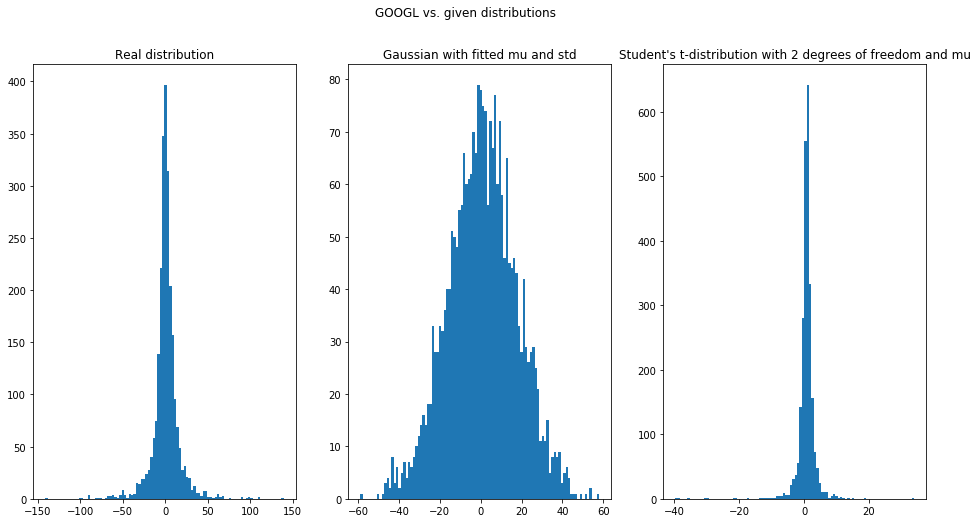

In [17]:
_, _, _, returns_googl, _, _ = returns_vs_plots(daily_returns, 'GOOGL', 2)

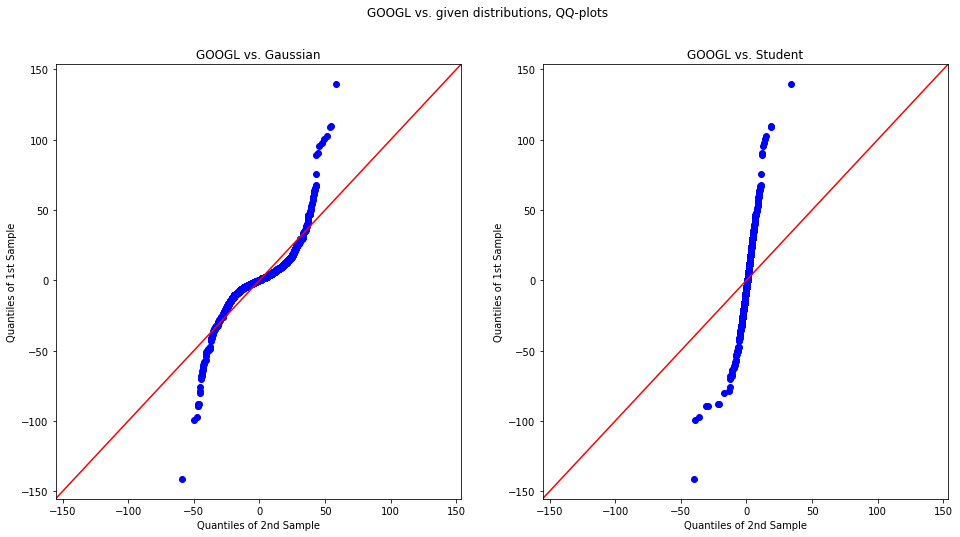

In [18]:
qqplots(daily_returns, 'GOOGL', 2)

# qqplots are not very close to a line => doesn't look like gaussian or student

In [19]:
goodness_of_fit_tests(daily_returns, 'GOOGL')

# pvalues are smaller than 0.05 => rejecting both null hypotheses (that returns are normally or exponentially distributed) at 0.05 level

,statistic,pvalue
Lilliefors_norm,0.141787,3.868610e-140
Lilliefors_exp,0.467620,1.000000e-02


ADF Statistic: -11.056513
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


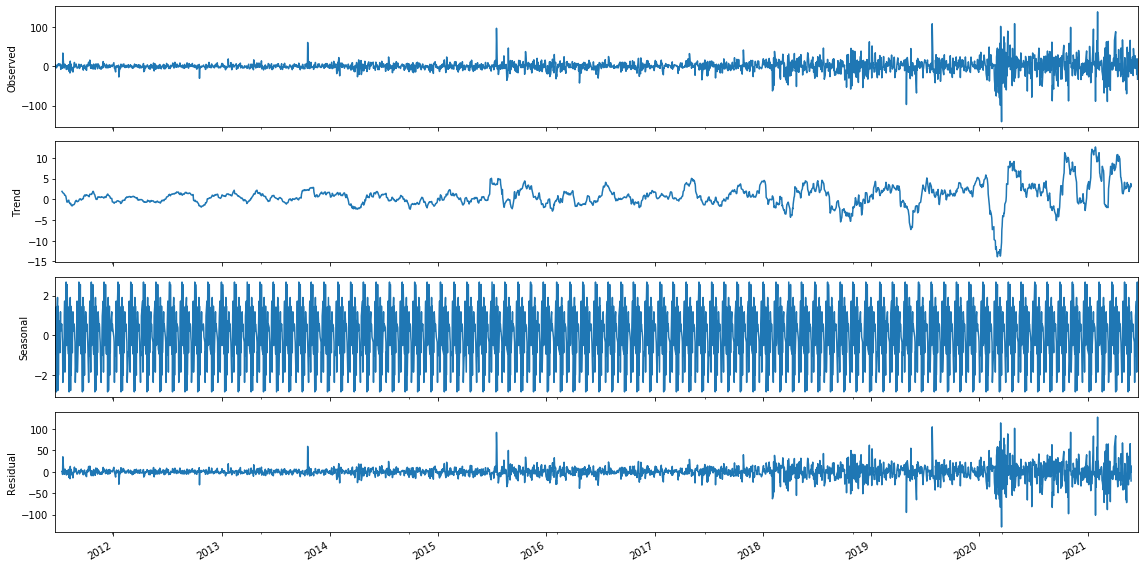

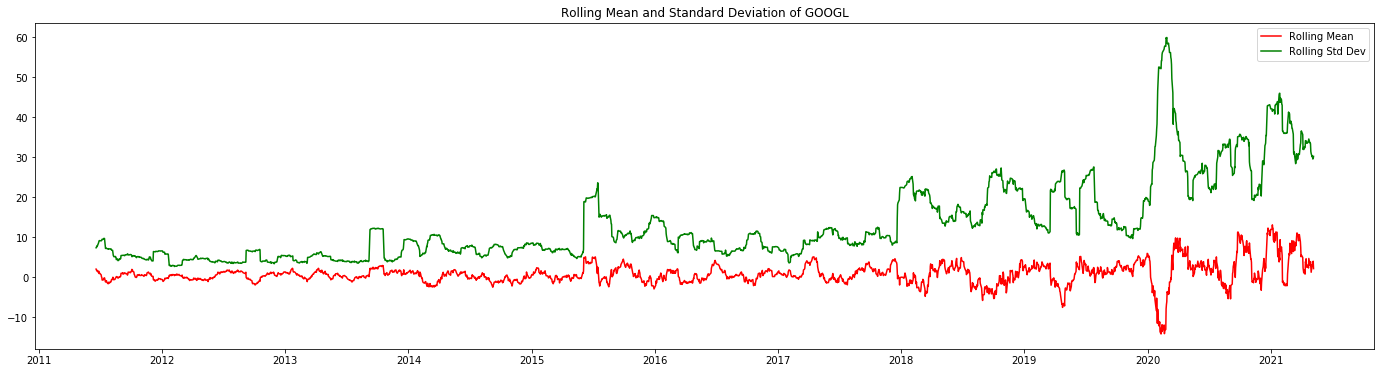

In [20]:
stationary_analysis(daily_returns, 'GOOGL')

# highly unlikely that our data is stationary as rolling mean and std are changing in time
# and pvalue for ADF test is 0, so we reject the null hypothesis that the data is stationary

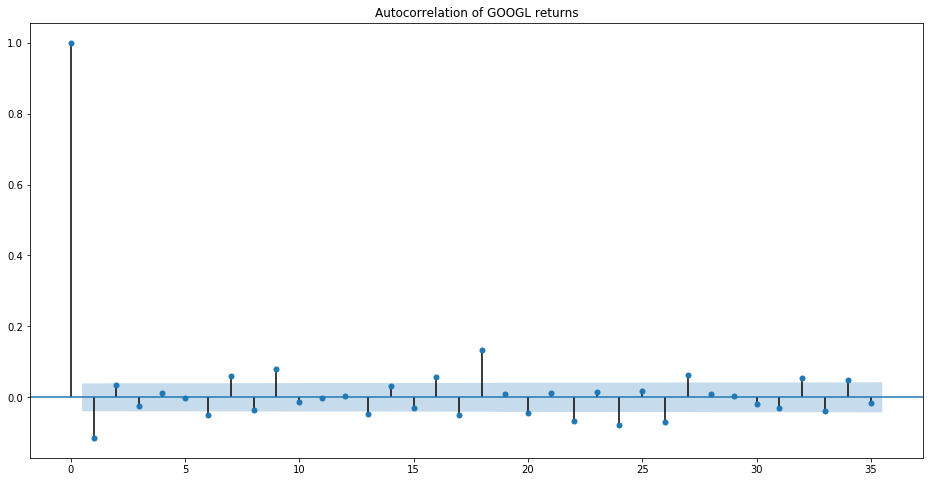

In [21]:
plot_acf(returns_aapl, title='Autocorrelation of GOOGL returns')
plt.show()

# as values of acf are close to zero, there is probably no dependency in our data

### FB

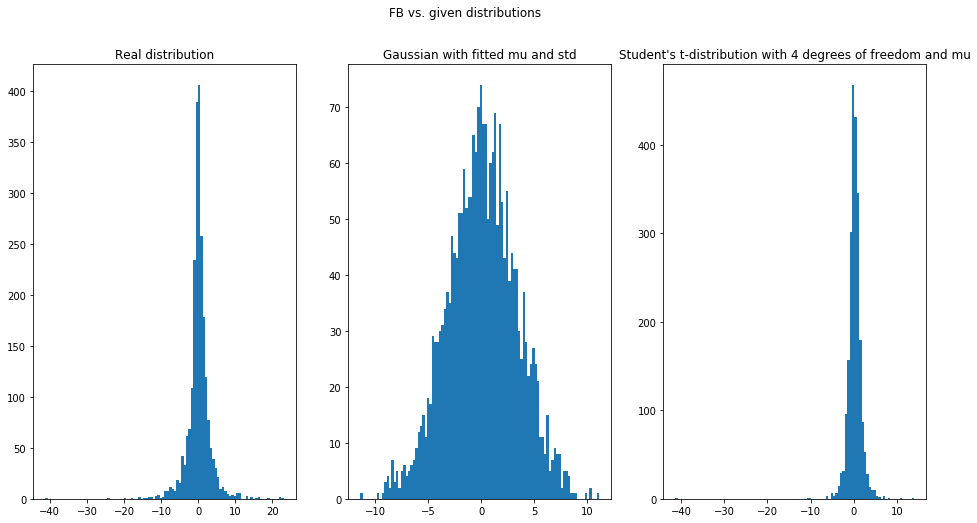

In [22]:
_, _, _, returns_fb, _, _ = returns_vs_plots(daily_returns, 'FB')

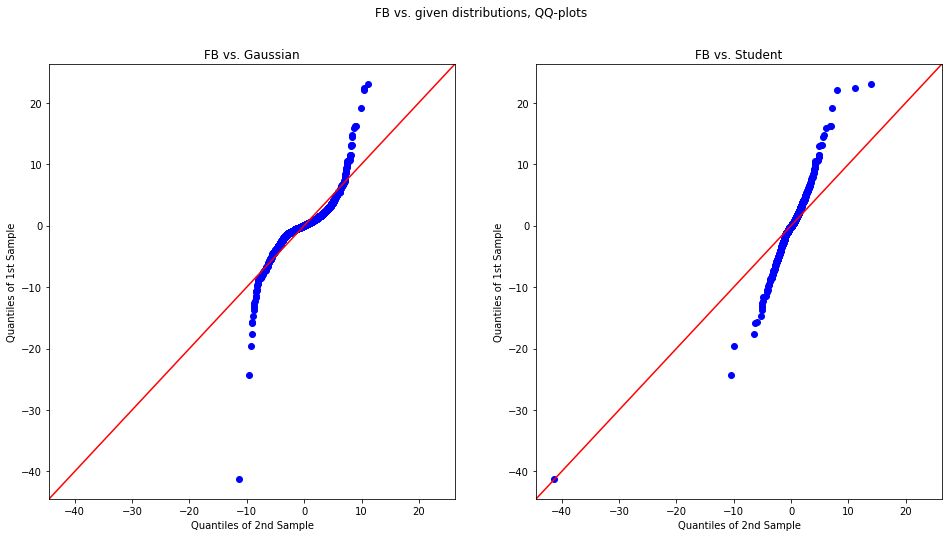

In [23]:
qqplots(daily_returns, 'FB')

# qqplots are not very close to a line => doesn't look like gaussian or student

In [24]:
goodness_of_fit_tests(daily_returns, 'FB')

# pvalues are smaller than 0.05 => rejecting both null hypotheses (that returns are normally or exponentially distributed) at 0.05 level

,statistic,pvalue
Lilliefors_norm,0.142025,1.425286e-127
Lilliefors_exp,0.473961,1.000000e-02


ADF Statistic: -10.202172
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


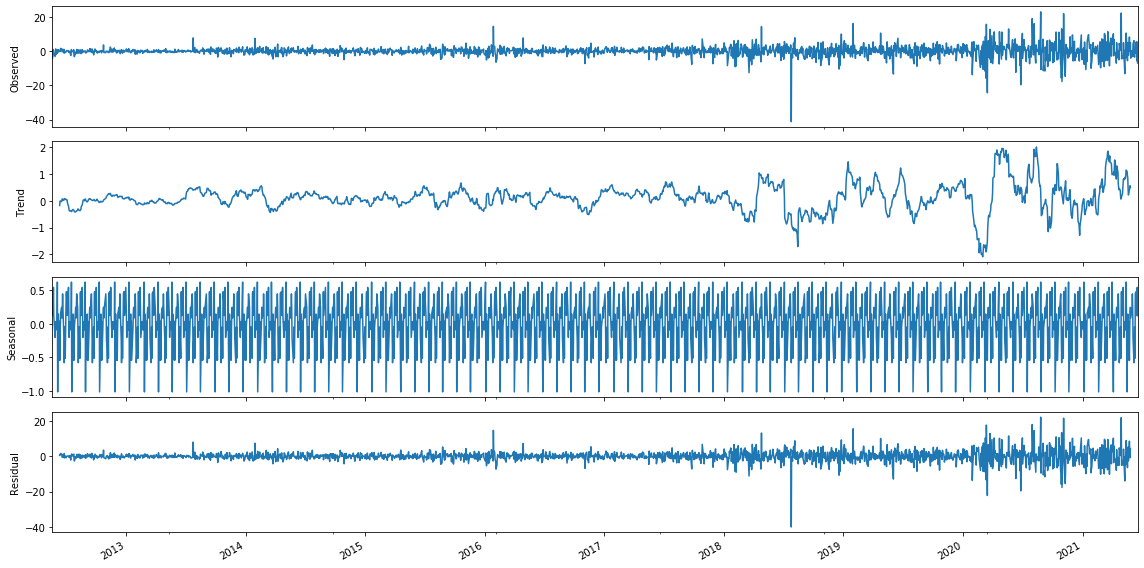

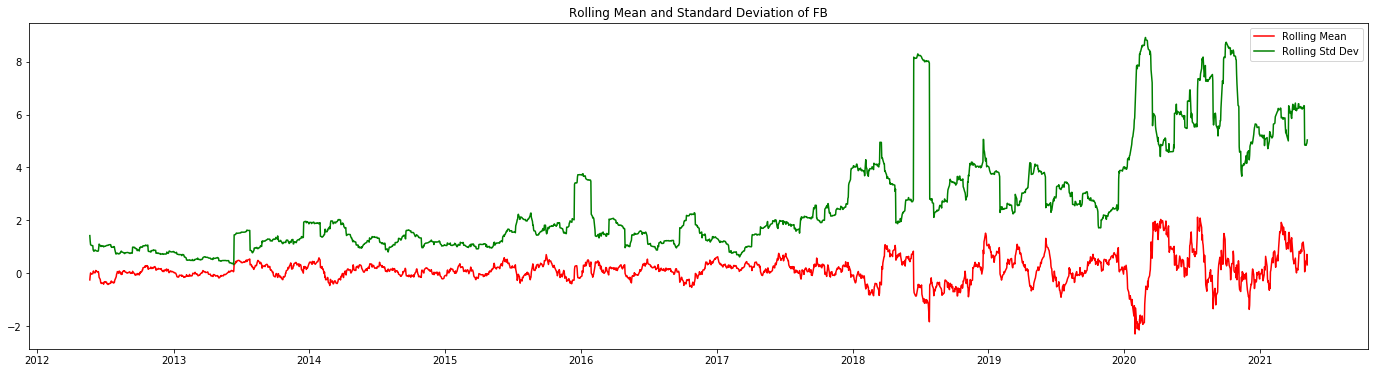

In [25]:
stationary_analysis(daily_returns, 'FB')

# highly unlikely that our data is stationary as rolling mean and std are changing in time
# and pvalue for ADF test is 0, so we reject the null hypothesis that the data is stationary

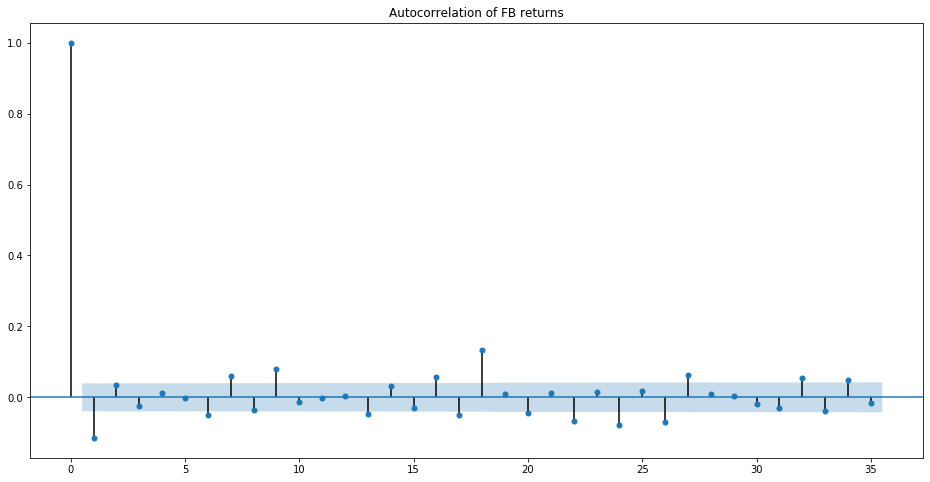

In [26]:
plot_acf(returns_aapl, title='Autocorrelation of FB returns')
plt.show()

# as values of acf are close to zero, there is probably no dependency in our data

In [27]:
# Granger Causality tests

grangercausalitytests(daily_returns.drop('FB', axis=1).dropna(), 4)
grangercausalitytests(daily_returns.drop('AAPL', axis=1).dropna(), 4)
grangercausalitytests(daily_returns.drop('GOOGL', axis=1).dropna(), 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4912  , p=0.0342  , df_denom=2513, df_num=1
ssr based chi2 test:   chi2=4.4965  , p=0.0340  , df=1
likelihood ratio test: chi2=4.4925  , p=0.0340  , df=1
parameter F test:         F=4.4912  , p=0.0342  , df_denom=2513, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0484  , p=0.1292  , df_denom=2510, df_num=2
ssr based chi2 test:   chi2=4.1049  , p=0.1284  , df=2
likelihood ratio test: chi2=4.1015  , p=0.1286  , df=2
parameter F test:         F=2.0484  , p=0.1292  , df_denom=2510, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6651  , p=0.0463  , df_denom=2507, df_num=3
ssr based chi2 test:   chi2=8.0176  , p=0.0456  , df=3
likelihood ratio test: chi2=8.0048  , p=0.0459  , df=3
parameter F test:         F=2.6651  , p=0.0463  , df_denom=2507, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0397  , p=0.

{1: ({'ssr_ftest': (3.3035799476157877, 0.06926021099054308, 2281.0, 1),
   'ssr_chi2test': (3.3079248576740286, 0.06894650425492961, 1),
   'lrtest': (3.305531728715323, 0.06904699591844708, 1),
   'params_ftest': (3.3035799476161265, 0.069260210990519, 2281.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.6040090674633398, 0.2013157525817059, 2278.0, 2),
   'ssr_chi2test': (3.2150594389980727, 0.20038200293875486, 2),
   'lrtest': (3.212797741010945, 0.20060873289961823, 2),
   'params_ftest': (1.6040090674635041, 0.20131575258168347, 2278.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.0818660642454905, 0.35551346603569306, 2275.0, 3),
   'ssr_chi2test': (3.2555846487141227, 0.3538724284995755, 3),
   'lrtest': (3.253264586986006, 0.3542004916071761, 3),
   'params_ftest': (1.0818660642455222, 0.35551346603569306, 2275.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0.

# Task 3

# Task 4

In [30]:
random_guess = np.random.normal(size=(n_aapl+1))
df = pd.DataFrame(random_guess, index=daily_returns.index, columns=['random_guess'])
df = df.diff(-1)

In [31]:
df = pd.concat([daily_returns['AAPL'], df], axis=1, sort=False).dropna()

In [32]:
hit_rate_df = df[((df['AAPL'] > 0) & (df['random_guess'] > 0)) | ((df['AAPL'] < 0) & (df['random_guess'] < 0))]

In [33]:
hit_rate = len(hit_rate_df) / len(df)
hit_rate

0.4974175605880016

# Task 5

In [34]:
df = pd.read_csv('./xtask.csv')

In [35]:
df.head()

,a,b,c,d,class
0,-0.233408,-0.845698,0.365256,0.311292,1.0
1,0.073524,-0.747284,0.586381,0.303840,1.0
2,0.105561,-0.749805,0.149815,0.635771,1.0
3,-0.642419,-0.342424,-0.608454,0.229135,0.0
4,0.296581,-0.656553,0.022429,0.639708,0.0


In [36]:
df_train = df.dropna()
df_test = df[df['class'].isna()]

In [37]:
X_train = df_train.drop('class', axis=1)
y_train = df_train['class']

X_test = df_test.drop('class', axis=1)

In [38]:
X_train.describe()

# features' values are close to each other, means are close to 0 => no need in normalization

,a,b,c,d
count,3071.000000,3071.000000,3071.000000,3071.000000
mean,-0.002720,-0.000529,-0.004356,0.011408
std,0.492057,0.493647,0.487877,0.505907
min,-0.995371,-0.991212,-0.994118,-0.990012
25%,-0.399741,-0.404161,-0.398240,-0.389400
50%,-0.010718,-0.008298,-0.015014,0.001528
75%,0.398228,0.402412,0.381475,0.435223
max,0.995987,0.993865,0.983458,0.997183


In [39]:
y_train.value_counts()

# classes are a bit skewed towards positive ones

1.0    2026
0.0    1045
Name: class, dtype: int64

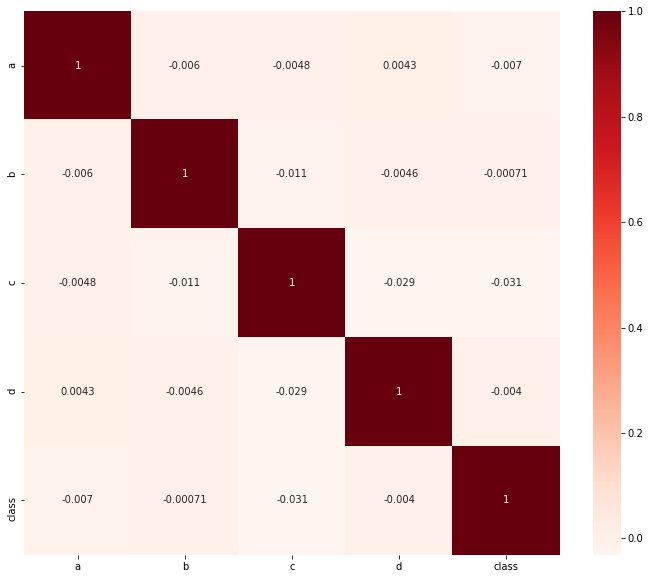

In [40]:
plt.figure(figsize=(12,10))
cor = df_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

# checking correlation

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

In [42]:
clf = RandomForestClassifier(random_state=1)

kf = KFold(n_splits=5, random_state=1, shuffle=True)
param_grid = {'n_estimators': range(1, 102, 50),
             'max_depth': range(1, 6),
             'min_samples_leaf': range(1, 11, 5)}

grid = GridSearchCV(clf, param_grid, cv=kf, scoring='f1')
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=1,
                                              verbose=0, warm_start=False),
      

In [43]:
res = (
    pd.DataFrame({
        "mean_test_score": grid.cv_results_["mean_test_score"],
        "mean_fit_time": grid.cv_results_["mean_fit_time"]})
      .join(pd.io.json.json_normalize(grid.cv_results_["params"]).add_prefix("param_"))
)
res

,mean_test_score,mean_fit_time,param_max_depth,param_min_samples_leaf,param_n_estimators
0,0.794934,0.004400,1,1,1
1,0.794934,0.096007,1,1,51
2,0.794934,0.159812,1,1,101
3,0.794934,0.003800,1,6,1
4,0.794934,0.078006,1,6,51
5,0.794934,0.157609,1,6,101
6,0.793811,0.004000,2,1,1
7,0.794934,0.099407,2,1,51
8,0.794934,0.186814,2,1,101
9,0.793811,0.004000,2,6,1


In [44]:
grid.best_score_

0.7949335039149487

In [45]:
grid.best_params_

{'max_depth': 1, 'min_samples_leaf': 1, 'n_estimators': 1}

In [46]:
clf = RandomForestClassifier(max_depth=2, min_samples_leaf=10, n_estimators=100, random_state=1)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [47]:
y_pred = clf.predict(X_test)
np.savetxt("Y_test.csv", y_pred, delimiter=",")